# Churn Analysis - Customer Churn

In [23]:
import sys
import os

# Tambah path src agar bisa import modul dari sana
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))


## 1. Import Libraries & Data

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from load_data import load_churn_data
from preprocessing import basic_clean, encode_features, scale_numeric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

In [ ]:
# Load data
df = load_churn_data() #nama kolom menjadi huruf kecil
df.head()

# Mengubah kolom sesuai sumber df
def rename_cols_for_func(df, expected_cols):
    current_cols = df.columns
    mapping = {}
    for expected in expected_cols:
        for actual in current_cols:
            if actual.lower() == expected.lower():
                mapping[actual] = expected
    return df.rename(columns=mapping)

df_source = pd.read_csv('../data/Telco-Customer-Churn.csv')
expected_cols = df_source.columns  # sesuai yang dipakai fungsi
df = rename_cols_for_func(df, expected_cols)
df = basic_clean(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   object  
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   object  
 4   Dependents        7032 non-null   object  
 5   tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   object  
 7   MultipleLines     7032 non-null   object  
 8   InternetService   7032 non-null   object  
 9   OnlineSecurity    7032 non-null   object  
 10  OnlineBackup      7032 non-null   object  
 11  DeviceProtection  7032 non-null   object  
 12  TechSupport       7032 non-null   object  
 13  StreamingTV       7032 non-null   object  
 14  StreamingMovies   7032 non-null   object  
 15  Contract          7032 non-null   object  
 16  PaperlessBilling  7032 non-nu

c:\Users\ACER\churn-analysis\src\preprocessing.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')


## 2. Statistik Deskriptif & Visualisasi

In [26]:
# Ukuran dataset
print("Jumlah baris:", df.shape[0], "Jumlah kolom:", df.shape[1])

# Churn rate
churn_rate = df['Churn'].map({'Yes':1, 'No':0}).mean()
print(f"Churn rate (Python): {churn_rate:.2%}")

Jumlah baris: 7032 Jumlah kolom: 21
Churn rate (Python): 26.58%


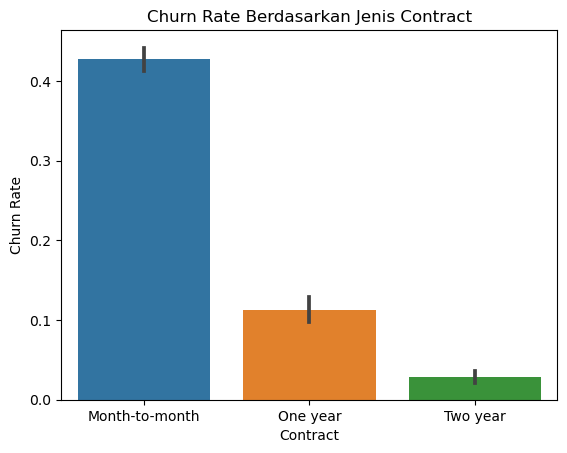

In [27]:
# Distribusi tingkat churn berdasarkan kategori contract
df_plot = df.copy()
df_plot['ChurnNumeric'] = df_plot['Churn'].map({'Yes':1, 'No':0})
sns.barplot(x='Contract', y='ChurnNumeric', data=df_plot)
plt.title('Churn Rate Berdasarkan Jenis Contract')
plt.ylabel('Churn Rate')
plt.xlabel('Contract')
plt.show()

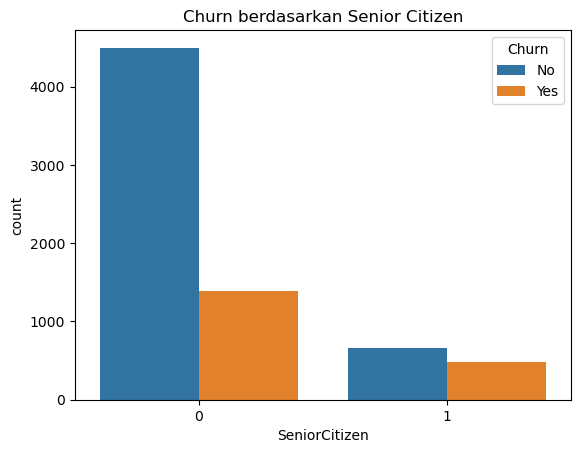

In [28]:
# Tingkat churn berdasarkan Senior Citizen (Distribusi Umur)
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Churn berdasarkan Senior Citizen')
plt.show()

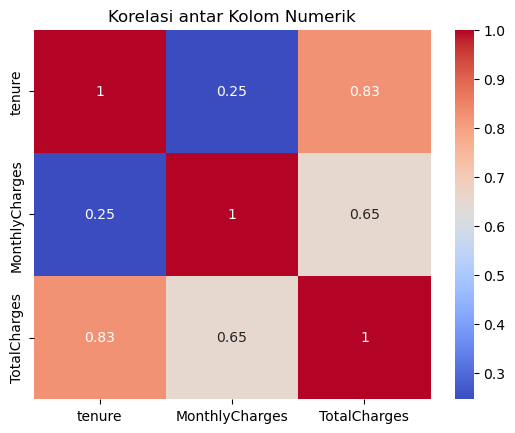

In [29]:
# Visualisasi korelasi fitur numerik
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasi antar Kolom Numerik')
plt.show()

- Tingkat churn sebesar 26.58% dengan kategori kontrak tertinggi pada month-to-month
- Gap terbesar pada customer dengan usia muda
- Korelasi tertinggi yaitu antara tenure dengan TotalCharges (semakin lama berlangganan semakin besar biaya) tetapi korelasi lemah untuk tenure dan monthlycharges

# 3. Hasil SQL

- Secara umum terdapat sedikit perbedaan untuk tingkat churn_rate karena terdapat baris yang didrop akibat dari nilai "TotalCharges" yang kosong

### Hasil SQL - 01_explore_customer.sql

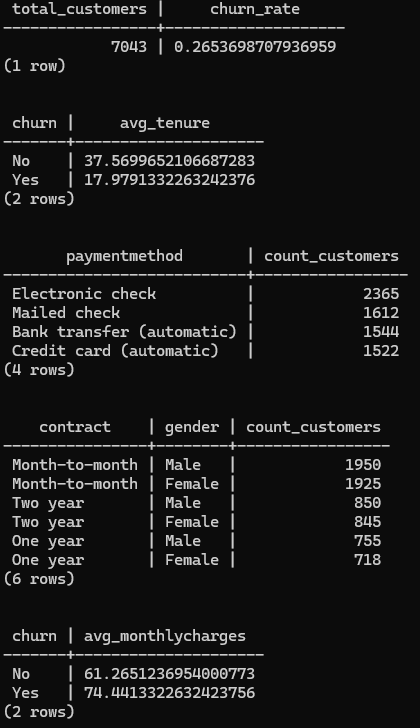
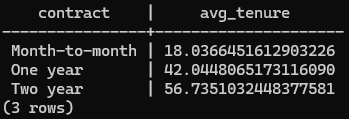

### Hasil SQL - 02_aggregate_contracts.sql
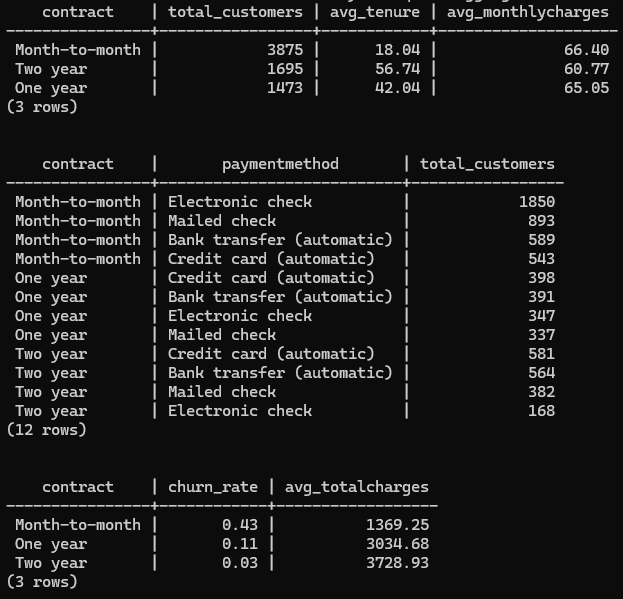

### Hasil SQL - 03_churn_behavior_case.sql

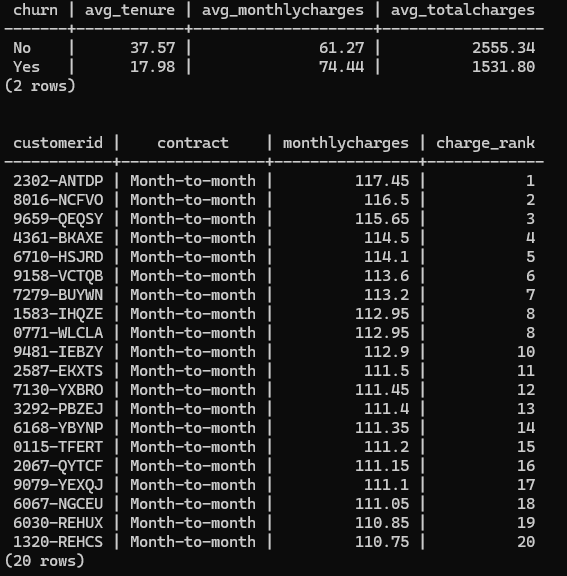
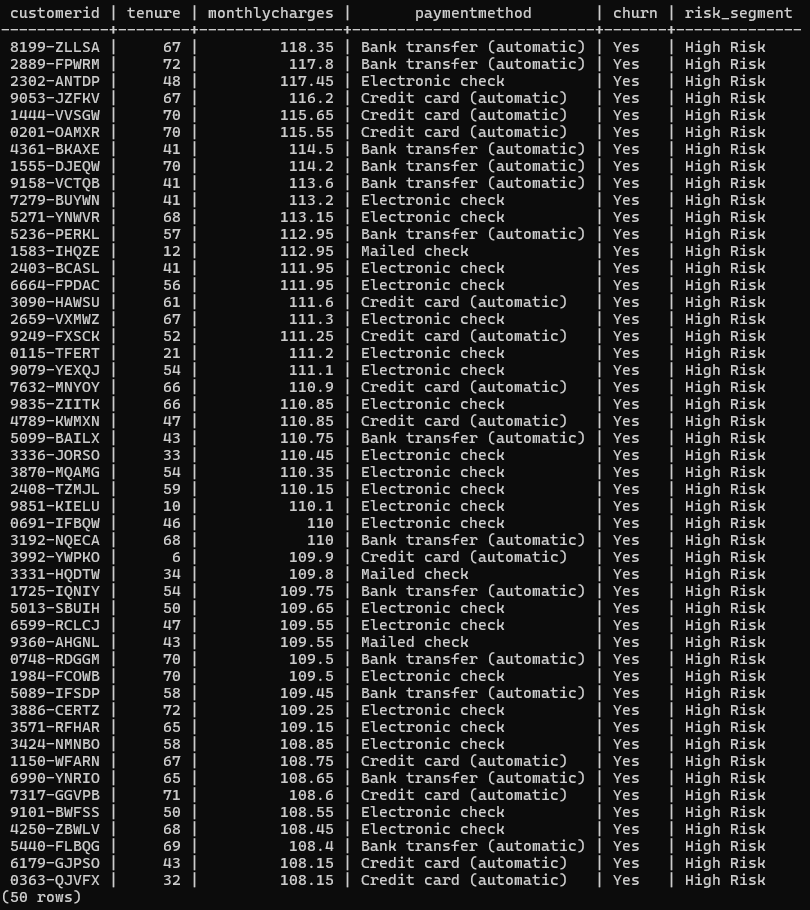

# 4. Feature Engineering

In [30]:
# Salin df sebelum encoding
df_fe = df.copy()

# Encode & scale
df_encoded = encode_features(df_fe)
df_final = scale_numeric(df_encoded)

# Cek dimensi & kolom
print("Shape Final:", df_final.shape)
df_final.head()

Shape Final: (7032, 30)


,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ChurnFlag
0,0,-1.280248,0,-1.161694,-0.994194,False,True,False,False,True,...,False,False,False,False,False,True,False,True,False,0
1,0,0.064303,1,-0.260878,-0.173740,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,0
2,0,-1.239504,0,-0.363923,-0.959649,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,1
3,0,0.512486,1,-0.747850,-0.195248,True,False,False,False,True,...,True,False,False,False,False,False,False,False,False,0
4,0,-1.239504,0,0.196178,-0.940457,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,1


In [ ]:
# Menentukan Fitur & Target
X = df_final.drop(columns=['ChurnFlag'])
y = df_final['ChurnFlag']

# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Jumlah train:", X_train.shape[0], "Jumlah test:", X_test.shape[0])

Jumlah train: 5625 Jumlah test: 1407


- Data sudah siap digunakan untuk modeling

# 5. Modeling

## 5.1 Logistic Regression

In [35]:
# Inisialisasi dan pelatihan
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Prediksi
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Evaluasi
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1033
           1       0.67      0.56      0.61       374

    accuracy                           0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407

ROC AUC: 0.8488385937847813


- Model Logistic Regression belum cukup baik dalam mengklasifikasikan customer churn

## 5.2 Random Forest

In [37]:
# Inisialisasi dan pelatihan
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prediksi
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluasi
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.46      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.8186580801466057


- Model Random Forest tidak lebih baik dibandingkan model Logistic Regression

# 6. Evaluasi

## 6.1 Feature Importance

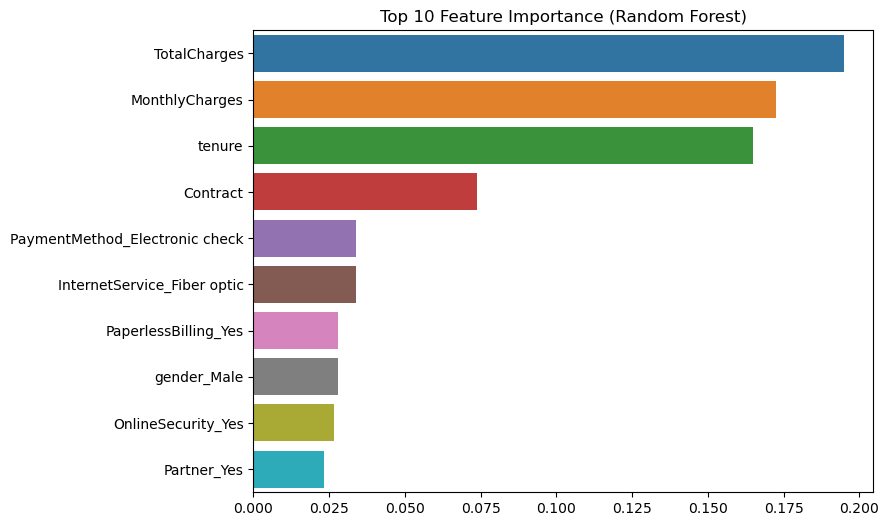

In [39]:
# Feature Importance berdasarkan hasil Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title('Top 10 Feature Importance (Random Forest)')
plt.show()

- TotalCharges memiliki nilai paling tinggi sehingga dapat dikatakan bahwa besarnya tagihan yang dibayar memengaruhi tingkat churn
- Hal ini diperkuat dengan MonthlyCharges dan Tenure yang bernilai tinggi juga sehingga pelanggan dengan tagihan besar dan durasi pendek lebih berisiko untuk churn
- Contract menunjukkan fitur non-numerik yang paling memengaruhi sehingga dapat dikatakan kontrak bulanan paling rentang churn

## 6.2 ROC Curve

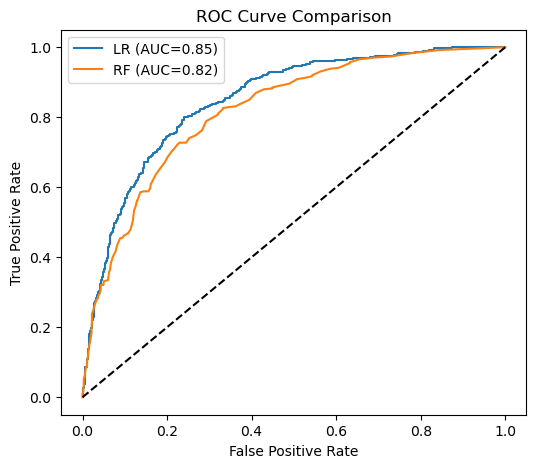

In [42]:
# ROC Curve untuk kedua model (LR dan RF)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={roc_auc_score(y_test, y_proba_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_score(y_test, y_proba_rf):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

- Model RF (AUC=0.82) tidak sebaik LR (AUC=0.85) dalam melakukan klasifikasi tingkat churn (sebelum dilakukan tuning)

# 7. Simpan Hasil Prediksi

In [47]:
# Buat DataFrame berisi customerID dan proba churn
output_df = pd.DataFrame({
    'customerID': df_fe['customerID'].loc[y_test.index],
    'proba_churn': y_proba_lr,   # gunakan model LR
    'pred_churn': y_pred_lr
})

# Simpan ke CSV
output_df.to_csv('../data/churn_predictions.csv', index=False)

Hasil prediksi dimasukkan ke PostgreSQL dan ditampilkan rata-rata probabilitas dalam memprediksi churn

**Average Predicted Churn Probability per Contract**
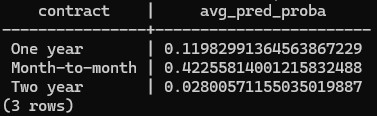